In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import rasterio
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.plot
from rasterio.plot import plotting_extent
import whitebox
%matplotlib inline
wbt = whitebox.WhiteboxTools()
wbt.set_working_dir(".")

In [2]:
wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir("/srv/conda/envs/notebook/lib/python3.10/site-packages/whitebox/whitebox_tools")
print(wbt.exe_path)
import os
print("Exists:", os.path.isfile(wbt.exe_path))
print("Executable:", os.access(wbt.exe_path, os.X_OK))

wbt = whitebox.WhiteboxTools()
# print("WhiteboxTools exe path:", wbt.exe_path)  # Should print the path to whitebox_tools.exe

/srv/conda/envs/notebook/lib/python3.10/site-packages/whitebox/whitebox_tools
Exists: True
Executable: True


EPSG:32760


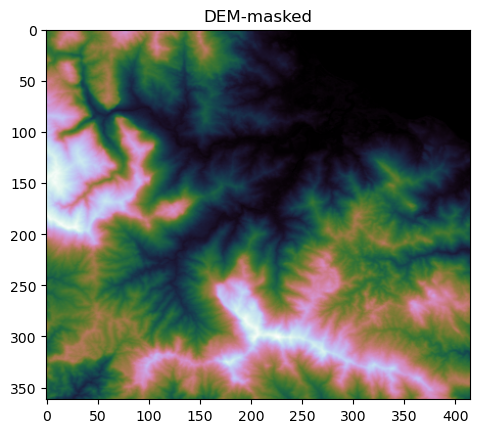

In [6]:
with rasterio.open('0-dem.tif') as src:
    data = src.read(1)
print(src.crs)
plt.imshow(data, cmap='cubehelix', vmin=0)
plt.title('DEM-masked')
plt.show()

In [7]:
# Preprocess crs of pourpoints:

pourpoints = gpd.read_file("pourpoints/Pourpoint.shp")
pourpoints = pourpoints.to_crs("EPSG:32760")
pourpoints.to_file("pourpoints/pourpoint_utm.shp")
print(pourpoints.crs)

EPSG:32760


In [ ]:
with rasterio.open(
    '4-d8-flowdir2.tif', 'w',
    driver='GTiff',
    height=array.shape[0],
    width=array.shape[1],
    count=1,
    meta = src.meta.copy()
    meta.update({'nodata': -9999})  # or whatever value is appropriate
    with rasterio.open('output.tif', 'w', **meta) as dst:
    dst.write(array, 1)
    dtype=array.dtype,
    crs='EPSG:32760',  # or your CRS
    transform=transform  # must be set correctly
) as dst:
    dst.write(array, 1)

In [8]:
import whiteboxgui
whiteboxgui.show()

In [ ]:
raster_path = "/home/jovyan/hydrology-modelling/wbt/dawasamu/4-d8-flow-direction.tif"
points_path = "/home/jovyan/hydrology-modelling/wbt/dawasamu/pourpoints/snapped-pourpoints.shp"

with rasterio.open(raster_path) as src:
    raster = src.read(1)
    nodata = src.nodata
    points = gpd.read_file(points_path)
    if points.crs != src.crs:
        points = points.to_crs(src.crs)
    for idx, row in points.iterrows():
        x, y = row.geometry.x, row.geometry.y
        rowcol = src.index(x, y)
        try:
            val = raster[rowcol[0], rowcol[1]]
            print(f"Point {idx} at ({x}, {y}): Value = {val}")
        except IndexError:
            print(f"Point {idx} at ({x}, {y}): OUTSIDE raster")

### 2. Fill nodata

2.1. Filter Dimension : 11

2.2. IDW Weight (exponent) value : 2.0

##### Input: `1-dem-masked`
##### Output: `2-cleared-nodata-dem`

### 3. FillDepressions

2.1. Flat increment 
Use a value just above the DEM’s vertical precision (i.e. 0.01 for cm, 1.00 for m

2.2. Max depth
Leave blank or set very high if you want to fill all depressions (the most common case).
##### Input: `2-cleared-nodata-dem`
##### Output: `3-filled-dem`

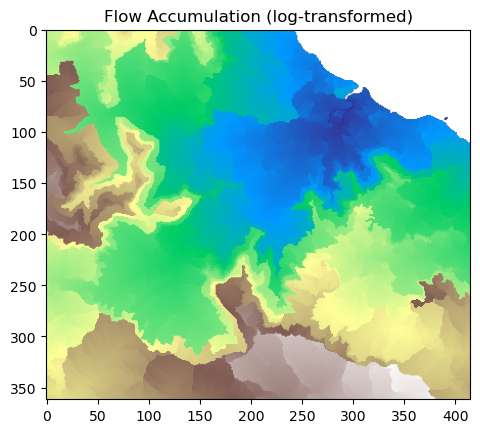

In [5]:
with rasterio.open('3-filled-dem.tif') as src:
    data = src.read(1)
    # Optional: log transform for better visualization
    # data = np.log1p(data)
    plt.imshow(data, cmap='terrain', vmin=0)
    plt.title('Flow Accumulation (log-transformed)')
    plt.show()

#### 4. D8Pointer
Generate Flow direction d8 pointer. Input DEM File, select ouptut file path.
##### Input: `3-filled-dem`
##### Output: `4-d8-flow-direction`

In [ ]:
with rasterio.open('4-d8-flow-direction.tif') as src:
    data = src.read(1)
    print(src.crs)
    # Optional: log transform for better visualization
    plt.imshow(data, cmap='cubehelix', vmin=0)
    plt.title('Flow Direction')
    plt.show()

#### 5. D8FlowAccumulation 
Generate Flow accumulation. Input DEM File, select ouptut file path. 
##### Input: `4-d8-flow-direction`
##### Output: `5-d8-flow-accumulation`
a) output type: catchment area  
b) exponent parameter: leave at default 1.1.  
c) is the input raster the d8: tick if yes   
d) convergence threshold: for d8 leave this blank  
e) log transform output: tick if there are several orders of magnitude you want to visualise  
f) clip the upper tail by 1%?: Tick for visualisation

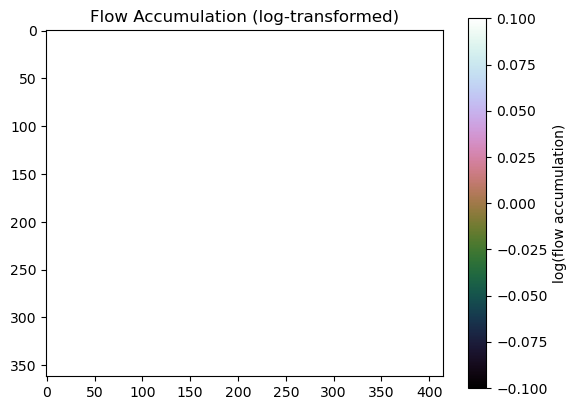

In [7]:
with rasterio.open('5-d8-flow-accumulation.tif') as src:
    data = src.read(1)
    # Optional: log transform for better visualization
    data_log = np.log1p(data)
    plt.imshow(data_log, cmap='cubehelix', vmin=0)
    plt.colorbar(label='log(flow accumulation)')
    plt.title('Flow Accumulation (log-transformed)')
    plt.show()

#### 5. Extract streams tool  
In order to generate pourpoints given that we are not sure where exactly these should be. 
##### Input: `5-d8p-flowaccumulation`
##### Output: `6-extract-streams`
Channelization thresholds: Small watersheds: 50–500, Large areas: 1000–10000
Background value of zero: a) Use zero if you want to perform further raster math or masking. b) Use NoData if you want a clear delineation of "stream vs. not stream" in visualization.


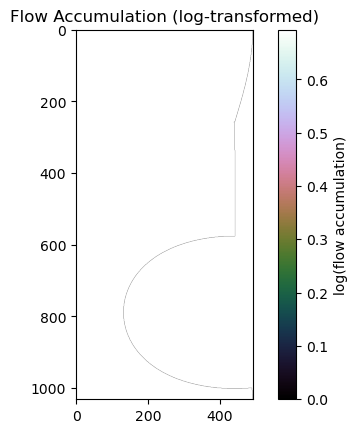

In [23]:
with rasterio.open('6-extract-streams.tif') as src:
    data = src.read(1)
    # Optional: log transform for better visualization
    data_log = np.log1p(data)
    plt.imshow(data_log, cmap='cubehelix', vmin=0)
    plt.colorbar(label='log(flow accumulation)')
    plt.title('Flow Accumulation (log-transformed)')
    plt.show()

6. Snap pourpoints
Firstly export flow accumulation and extract streams to QGIS. Then digitise pourpoints. Then rasterise. Burn a unique value for each point depending on the id: corresponding to each distinct catchment. Then upload and re-input.    

In order to generate pourpoints given that we are not sure where exactly these should be.

Input: 5-d8p-flowaccumulation
Output: 6-extract-streams